<a target="_blank" href="https://colab.research.google.com/github/arindamchoudhury/ml-projects/blob/main/MNIST_Handwritten_Digits.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

In this project, we will build a neural network of to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)



## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import multiprocessing

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load the Dataset

In [4]:
# Define transforms
# https://nextjournal.com/gkoehler/pytorch-mnist Normalize params 
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])

# Create training set and define training dataloader
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [50000, 10000])

# Create test set and define test dataloader
batch_size = 64
num_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:01<00:00, 6531458.43it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118877030.25it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8066355.32it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21429166.22it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Explore the Dataset


In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


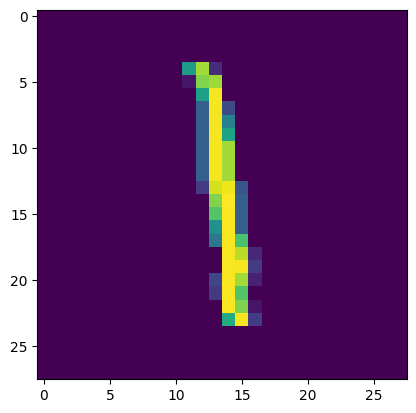

2


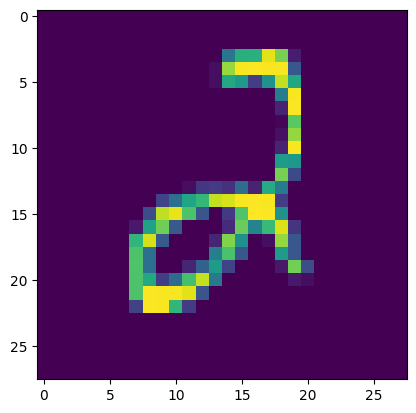

4


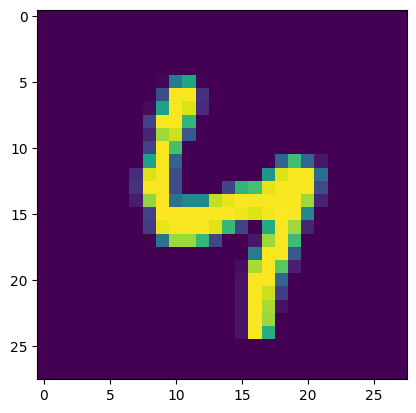

9


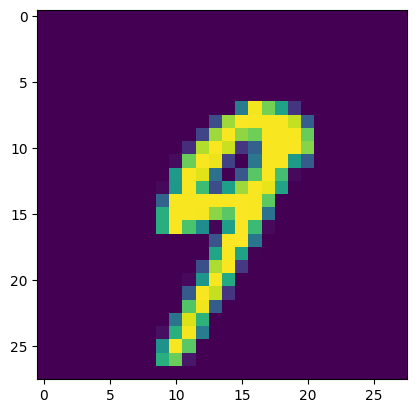

4


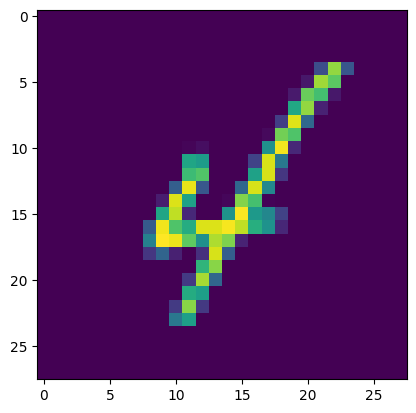

In [6]:
# Explore data
show5(train_loader)

## Build the Model

In [7]:
# base of the LeNet5 collected from https://github.com/rgkannan676/MNIST-Handwritten-Digit-Recognition/blob/main/OptmizerSelection.py
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.bn1 = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.bn2 = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = self.relu(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = out.view(-1,16*5*5)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = self.fc3(out)
        return out
    
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

## Running the Model

In [8]:
def accuracy(logits, labels):
    _, yhat = torch.max(logits.data, dim=1)
    equals = yhat == labels
    return torch.mean(equals.type(torch.FloatTensor))

In [9]:
# collected from https://www.coursera.org/projects/pneumonia-classification-using-pytorch
class ModelTrainer():
    def __init__(self, criterion = None, optimizer = None):        
        self.criterion = criterion
        self.optimizer = optimizer
  
    def train_batch_loop(self, model, trainloader):        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):            
            images = images.to(device)
            labels = labels.to(device)
            
            self.optimizer.zero_grad()
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):                
            images = images.to(device)
            labels = labels.to(device)
             
            logits = model(images)
            loss = self.criterion(logits, labels)
              
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs, filename):        
        valid_min_loss = np.Inf
        train_loss_history = list()
        valid_loss_history = list()
        
        for i in range(epochs):            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            train_loss_history.append(avg_train_loss)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)
            valid_loss_history.append(avg_valid_loss)
            
            if avg_valid_loss < valid_min_loss:
                print(f"validation loss decreased {valid_min_loss} --> {avg_valid_loss}")
                torch.save(model.state_dict(), filename)
                valid_min_loss = avg_valid_loss

                
            print(f"Epoch : {i+1} Train Loss : {avg_train_loss:.6f} Train Acc : {avg_train_acc:.6f}")
            print(f"Epoch : {i+1} Valid Loss : {avg_valid_loss:.6f} Valid Acc : {avg_valid_acc:.6f} Min Loss : {valid_min_loss:.6f}")
        
        return train_loss_history, valid_loss_history

In [10]:
optimizer =  optim.Adam(net.parameters(), lr=0.003, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

trainer = ModelTrainer(criterion, optimizer)
train_loss_history, valid_loss_history = trainer.fit(model=net, trainloader=train_loader, validloader=valid_loader, epochs=20, filename="leNet.pt")

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased inf --> 0.7000673014646882
Epoch : 1 Train Loss : 0.512985 Train Acc : 0.943035
Epoch : 1 Valid Loss : 0.700067 Valid Acc : 0.944467 Min Loss : 0.700067


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.7000673014646882 --> 0.5080578226572389
Epoch : 2 Train Loss : 0.547347 Train Acc : 0.957521
Epoch : 2 Valid Loss : 0.508058 Valid Acc : 0.968949 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.533591 Train Acc : 0.959159
Epoch : 3 Valid Loss : 0.631218 Valid Acc : 0.954717 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.527226 Train Acc : 0.957581
Epoch : 4 Valid Loss : 0.537484 Valid Acc : 0.951334 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.520665 Train Acc : 0.959039
Epoch : 5 Valid Loss : 0.518825 Valid Acc : 0.947552 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.516804 Train Acc : 0.959239
Epoch : 6 Valid Loss : 0.616411 Valid Acc : 0.949542 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.512079 Train Acc : 0.960418
Epoch : 7 Valid Loss : 0.583247 Valid Acc : 0.948945 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.509368 Train Acc : 0.959459
Epoch : 8 Valid Loss : 0.585347 Valid Acc : 0.930533 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.505053 Train Acc : 0.962256
Epoch : 9 Valid Loss : 0.555747 Valid Acc : 0.952030 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.507691 Train Acc : 0.960718
Epoch : 10 Valid Loss : 0.557821 Valid Acc : 0.959793 Min Loss : 0.508058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.5080578226572389 --> 0.501300598215905
Epoch : 11 Train Loss : 0.509560 Train Acc : 0.959099
Epoch : 11 Valid Loss : 0.501301 Valid Acc : 0.944765 Min Loss : 0.501301


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

validation loss decreased 0.501300598215905 --> 0.429269326150797
Epoch : 12 Train Loss : 0.509555 Train Acc : 0.959459
Epoch : 12 Valid Loss : 0.429269 Valid Acc : 0.955713 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.508099 Train Acc : 0.959998
Epoch : 13 Valid Loss : 0.622659 Valid Acc : 0.961186 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.510797 Train Acc : 0.960518
Epoch : 14 Valid Loss : 0.548533 Valid Acc : 0.949841 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.508000 Train Acc : 0.960478
Epoch : 15 Valid Loss : 0.549879 Valid Acc : 0.952130 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.507492 Train Acc : 0.961317
Epoch : 16 Valid Loss : 0.492853 Valid Acc : 0.960788 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.508959 Train Acc : 0.959898
Epoch : 17 Valid Loss : 0.489243 Valid Acc : 0.958400 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.510478 Train Acc : 0.960378
Epoch : 18 Valid Loss : 0.577382 Valid Acc : 0.960191 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.507248 Train Acc : 0.960977
Epoch : 19 Valid Loss : 0.448294 Valid Acc : 0.963376 Min Loss : 0.429269


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.511625 Train Acc : 0.959839
Epoch : 20 Valid Loss : 0.496449 Valid Acc : 0.951433 Min Loss : 0.429269


Plot the training loss and validation loss/accuracy:

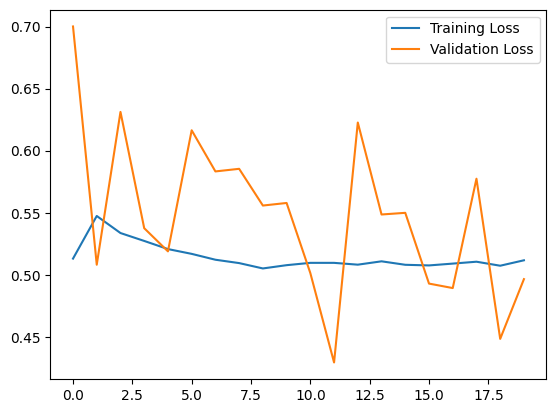

In [11]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing the model


In [12]:
test_net = LeNet5()
test_net.to(device)
test_net.load_state_dict(torch.load('leNet.pt'))
test_net.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(test_net, test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.4292802020053195
Test Acc : 0.9540206789970398


## Saving model

In [13]:
torch.save(net.state_dict(), "LeNetFinal.pt")